In [1]:
%pylab inline
import octopus
from pygadgetreader import readsnap
import biff
from astropy import units as u
from astropy import constants

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:841: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/ngaravito/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


Populating the interactive namespace from numpy and matplotlib


# To do: 

1. Do this with a HR halo.
2. Check the high order terms with my code.
3. Check why by changing the order of the particles different tearms appear. this is odd!

In [2]:
def re_center(pos, cm):
    """
    Re center a halo to its center of mass.
    """
    for i in range(3):
        pos[:,i] = pos[:,i] - cm[i]
    return pos

def biff_potential(pos, S, T, n,l,m):
    S_new = np.zeros(shape(S))
    T_new = np.zeros(shape(T))
    S_new[n,l,m] = S[n,l,m]
    T_new[n,l,m] = T[n,l,m]
    pot_nlm = biff.potential(pos.astype(double), S_new, T_new, G=G_c.value, M=1, r_s=3)
    #r = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    #indexes = argsort(r)
    return pot_nlm
    
def n_body_potential(pos, pot):
    r = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    indexes = argsort(r)
    return r[indexes], pot[indexes]

In [3]:
def high_order_terms(Coeff):
    """
    Identify the indices (n,l,m) of the terms which amplitude is larger than 
    the (n=0, l=0, m=0) term.
    Input:
    ------
        Coeff : float
            A 3d matrix of the coefficients.
    
    Output:
    -------
        n : list
           List with the ``n`` indices.
        l : list
           List with the ``l`` indices.
        m : list
           List with the ``m`` indices.
    """
    
    index = np.where(Coeff>Coeff[0,0,0])
    n = index[0]
    l = index[1]
    m = index[2]
    
    #print('n=', n)
    #print('l=', l)
    #print('m=', m)
    coeffs = np.array([n, l, m, Coeff[n,l,m]]).T
    return coeffs[coeffs[:,3].argsort()]


def pot_diff(pot1, pot2):
    dif = np.abs(np.abs(pot1)-np.abs(pot2))
    return dif

# Potential comparisson from the N body to the analytic and the SCF method

In [4]:
# Computing the center of mass of the halo.
pos_cm_LMC, vel_cm_LMC, a, b = octopus.orbit('../../data/ICs/LMC/LMC1-97k/', 'LMC1_97K_vir', 99, 100, 97000, 0.1)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs


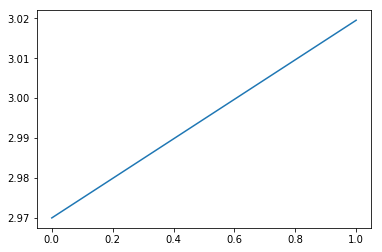

In [5]:
# CM trajectory.
rcm_LMC = np.sqrt(pos_cm_LMC[:,0]**2 + pos_cm_LMC[:,1]**2 + pos_cm_LMC[:,2]**2)
plot(rcm_LMC)

In [6]:
# Fisrt snapshot properties!
pos_LMC = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_100', 'pos', 'dm')
vel_LMC = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_100', 'vel', 'dm')
mass_LMC = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_100', 'mass', 'dm')
pid_LMC = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_100', 'pid', 'dm')
pot_LMC = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_100', 'pot', 'dm')

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Particle IDs
Returning DM    Potential


In [7]:
pos_cm_LMC[-1]

array([-2.73783931, -0.62749828,  1.10823757])

In [8]:
# Computing all the coefficients for the first snapshot
pos_LMC_centered = re_center(pos_LMC, pos_cm_LMC[-1])
S0, T0 = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_centered.astype(double))
                                      , mass_LMC.astype(double)*1E10, 10, 10, 3)

Remeber to correct by the fact that Gagdet have different units for G
this is:
$G=43007.1$

In [9]:
G_c = constants.G
G_c = G_c.to(u.kiloparsec**3 / (u.s**2 * u.Msun)) # 
pot_factor = G_c/43007.1 *1E10

In [10]:
r_lmc, pot_nb_lmc = n_body_potential(pos_LMC_centered, pot_LMC)

In [11]:
# Analytic potential
pot_an_lmc = octopus.pot_hernquist(3, r_lmc, 3E10)
# Biff potential
pot_biff_LMC = biff.potential(pos_LMC.astype(double), S0, T0, G=G_c.value, M=1, r_s=3)

In [12]:
r = np.sqrt(pos_LMC[:,0]**2 + pos_LMC[:,1]**2 + pos_LMC[:,2]**2)
indexes = argsort(r)


(1, 100)

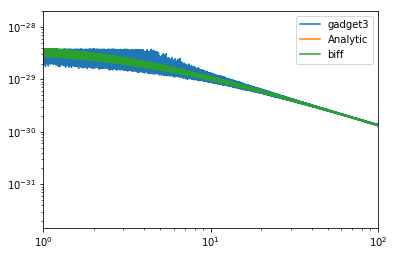

In [13]:
loglog(r_lmc, np.abs(pot_nb_lmc)*pot_factor, label='gadget3')
loglog(r_lmc, np.abs(pot_an_lmc), label='Analytic')
loglog(r[indexes], np.abs(pot_biff_LMC[indexes]), label='biff')
legend()
xlim(1, 100)

In [52]:
## Finding high order terms! 
hot_S0 = high_order_terms(S0)
print(hot_S0)

[[  0.00000000e+00   7.00000000e+00   1.00000000e+00   4.08439649e+10]
 [  1.00000000e+00   9.00000000e+00   4.00000000e+00   4.57235995e+10]
 [  0.00000000e+00   7.00000000e+00   4.00000000e+00   4.86536651e+10]
 [  0.00000000e+00   7.00000000e+00   2.00000000e+00   5.07740821e+10]
 [  1.00000000e+00   9.00000000e+00   8.00000000e+00   5.24491521e+10]
 [  0.00000000e+00   8.00000000e+00   2.00000000e+00   6.54710355e+10]
 [  2.00000000e+00   1.00000000e+01   4.00000000e+00   7.08945590e+10]
 [  1.00000000e+00   9.00000000e+00   7.00000000e+00   7.59868405e+10]
 [  1.00000000e+00   9.00000000e+00   6.00000000e+00   7.82478426e+10]
 [  2.00000000e+00   1.00000000e+01   9.00000000e+00   7.99780274e+10]
 [  1.00000000e+00   9.00000000e+00   1.00000000e+00   9.95459818e+10]
 [  0.00000000e+00   8.00000000e+00   0.00000000e+00   1.07291696e+11]
 [  1.00000000e+00   1.00000000e+01   3.00000000e+00   1.40407965e+11]
 [  1.00000000e+00   1.00000000e+01   9.00000000e+00   1.45828166e+11]
 [  0.

In [41]:
def high_order_grid(hot_S0):
    grid_coeff = np.zeros((11, 11))
    for i in range(11):
        for j in range(11):
            index = np.where((hot_S0[:,0]==i) & (hot_S0[:,1]==j))[0]
            #print(len(index))
            grid_coeff[i][j] = len(index)
    return grid_coeff

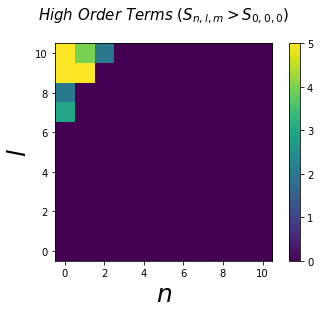

In [42]:
grid_coeff_vir_HR = high_order_grid(hot_S0)
imshow(grid_coeff.T, origin='lower')
colorbar()
xlabel('$n$', fontsize=25)
ylabel('$l$', fontsize=25)
title('$High\ Order\ Terms\ (S_{n,l,m}> S_{0,0,0})$', fontsize=15,  y=1.08)

In [ ]:
def grid_gen(xmin, xmax, ymin, ymax, zmin, zmax, n_spaces):
    """
    n_spaces : int
        space between points.
    """
    X, Y, Z = np.mgrid[xmin:xmax:n_spaces, ymin:ymax:n_spaces, zmin:zmax:n_spaces]
    cart_grid = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
    return cart_grid
    #figure(figsize=(5,5))
    #scatter(cart_grid[0], cart_grid[1], s=0.1)

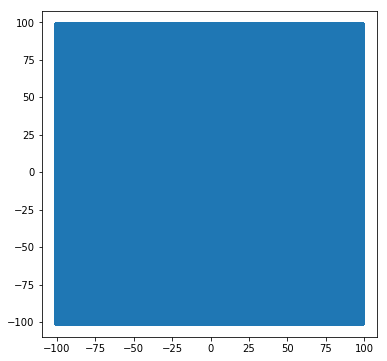

In [165]:
# Example of the grid
figure(figsize=(6,6))
grid_pos = grid_gen(-100, 100, -100, 100, -100, 100, 3)
scatter(grid_pos[0], grid_pos[1])

In [166]:
pot_biff_all_LMC = biff.potential(ascontiguousarray(grid_pos.T.astype(double)), S0, T0, G=G_c.value, M=1, r_s=3)
pot_biff_partial_LMC = biff_potential(ascontiguousarray(grid_pos.T), S0, T0, 0, 10, 9)
pot_biff_principal_LMC = biff_potential(ascontiguousarray(grid_pos.T), S0, T0, 0, 0, 0)

#pot_biff_partial_LMC

In [197]:
### computing differences in the potential!

In [183]:
pot_dif_all_all = pot_diff(pot_biff_all_LMC, pot_biff_all_LMC)
print(sum(pot_dif_all_all))

0.0


In [184]:
pot_dif_all_principal = pot_diff(pot_biff_all_LMC, pot_biff_principal_LMC)
print(sum(pot_dif_all_principal))

3.0990312109e-28


In [185]:
pot_dif_all_partial = pot_diff(pot_biff_all_LMC, pot_biff_partial_LMC)
print(sum(pot_dif_all_partial))

4.61786903561e-25


In [186]:
def scatter_slice(pos, pot, zmin, zmax):
    """
    Slices the 3d cartessian grid along the z-coordinate.
    
    """
    index = np.where((pos[:,2]<zmax) & ((pos[:,2]>zmin)))
    return pos[index], pot[index]
    

In [ ]:
### Visualizing the potential 

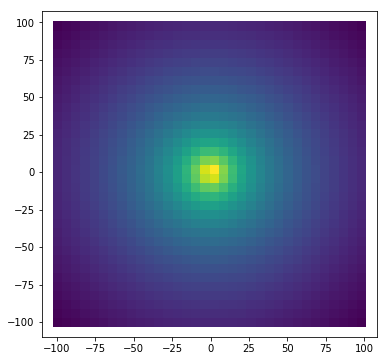

In [131]:
figure(figsize=(6,6))
pos_slice, pot_slice_all = scatter_slice(grid_pos.T, pot_biff_all_LMC, -5, 5)
scatter(pos_slice[:,0], pos_slice[:,1], c = np.log10(np.abs(pot_slice_all)/np.max(np.abs(pot_biff_all_LMC))), s=70, marker='s')

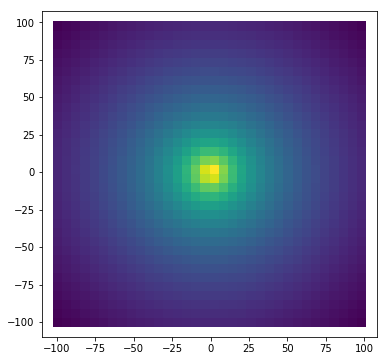

In [132]:
figure(figsize=(6,6))
pos_slice, pot_slice_principal = scatter_slice(grid_pos.T, pot_biff_principal_LMC, -5, 5)
scatter(pos_slice[:,0], pos_slice[:,1], c = np.log10(np.abs(pot_slice_principal)/np.max(np.abs(pot_biff_all_LMC))), s=70, marker='s')

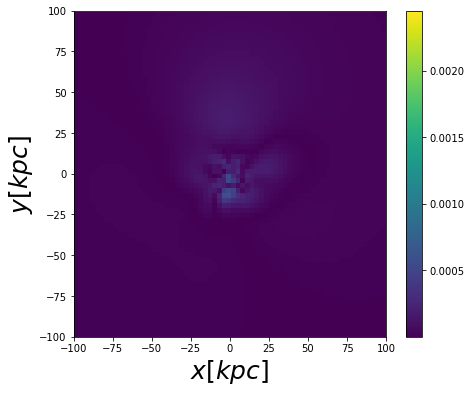

In [191]:
figure(figsize=(7,6))
pos_slice, pot_slice_dif_all_principal = scatter_slice(grid_pos.T, pot_dif_all_principal, 0, 10)
scatter(pos_slice[:,0], pos_slice[:,1], c = (np.abs(pot_slice_dif_all_principal)/np.max(np.abs(pot_biff_all_LMC)))
        ,s=17, marker='s')
xlabel('$x[kpc]$', fontsize=25)
ylabel('$y[kpc]$', fontsize=25)
xlim(-100,100)
ylim(-100,100)

colorbar()

In [ ]:
figure(figsize=(7,6))
pos_slice, pot_slice_partial = scatter_slice(grid_pos.T, pot_biff_partial_LMC, -25, -20)
scatter(pos_slice[:,0], pos_slice[:,1], c = np.log10(np.abs(pot_slice_partial)/np.max(np.abs(pot_biff_partial_LMC)))
        ,s=80, marker='s')
xlabel('$x[kpc]$', fontsize=25)
ylabel('$y[kpc]$', fontsize=25)
xlim(-100,100)
ylim(-100,100)

colorbar()

# Relaxation effect!

Does the relaxation have any inprint in the amplitude of the coefficients?


In [43]:
pos_LMC_i = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_000', 'pos', 'dm')
vel_LMC_i = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_000', 'vel', 'dm')
mass_LMC_i = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_000', 'mass', 'dm')
pid_LMC_i = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_000', 'pid', 'dm')

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Particle IDs


In [44]:
pos_cm_LMC_i, vel_cm_LMC_i, a, b = octopus.orbit('../../data/ICs/LMC/LMC1-97k/', 'LMC1_97K_vir', 0, 1, 97000, 0.1)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs


In [45]:
pos_LMC_i_centered = re_center(pos_LMC_i, pos_cm_LMC_i[0])
#pos_LMC_i_centered = re_center(pos_LMC_i, pos_cm_LMC[0])
#octopus.CM(pos_LMC_centered,  vel_LMC)
#S0_cm, T0_cm = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_centered.astype(double)), mass_LMC.astype(double), 10, 10, 3)
S0i_cm, T0i_cm = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_i_centered.astype(double)), mass_LMC.astype(double), 10, 10, 3)

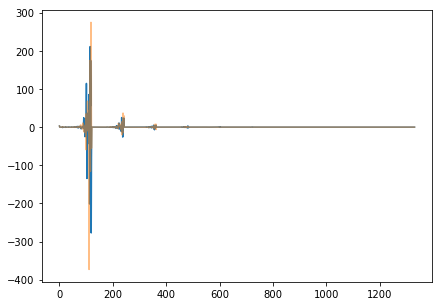

In [148]:
figure(figsize=(7,5))
plot(S0_cm.flatten(), alpha=1)
plot(S0f_cm.flatten(), alpha=0.5)

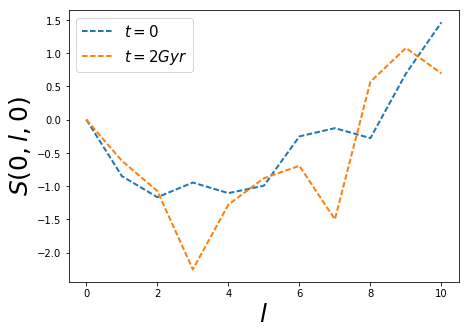

In [147]:
figure(figsize=(7,5))

plot(np.log10(np.abs(S0_cm[0,:,0])/np.abs(S0_cm[0,0,0])), lw=2, ls='--', label='$t=0$')
plot(np.log10(np.abs(S0f_cm[0,:,0])/np.abs(S0f_cm[0,0,0])), lw=2, ls='--', label='$t=2Gyr$')
legend(fontsize=15)
xlabel('$l$', fontsize=25)
ylabel('$S(0, l, 0)$', fontsize=25)

In [48]:
hot_S0i = high_order_terms(S0i_cm)
print(hot_S0i)
print(hot_S0)


[[   3.           10.            8.            3.18454445]
 [   1.            9.            5.            3.22643382]
 [   2.           10.           10.            3.2836815 ]
 [   1.            9.            2.            3.62263396]
 [   1.            8.            5.            3.76388666]
 [   1.           10.            5.            3.92161601]
 [   2.           10.            1.            4.98046042]
 [   1.           10.            9.            5.16535641]
 [   2.           10.            9.            5.2762421 ]
 [   0.            8.            2.            6.51094925]
 [   1.            9.            4.            8.53210232]
 [   1.            9.            3.           10.87786986]
 [   0.            8.            7.           21.34521019]
 [   1.           10.           10.           23.97605863]
 [   0.            8.            3.           24.61589667]
 [   1.           10.            2.           25.04815464]
 [   0.           10.            2.           25.2206927

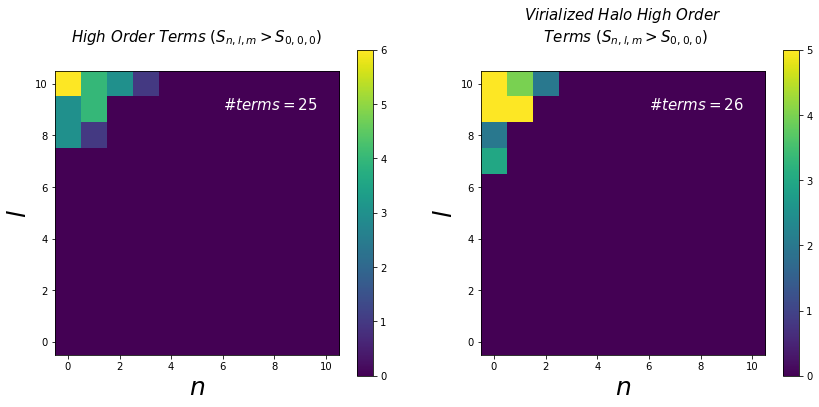

In [89]:
grid_coeff_novir_HR = high_order_grid(hot_S0i)
figure(figsize=(14, 6))
subplot(1, 2, 1)
imshow(grid_coeff_novir_HR.T, origin='lower')
colorbar()
xlabel('$n$', fontsize=25)
ylabel('$l$', fontsize=25)
text(6, 9, '$\# terms = $'+str(len(hot_S0i)), color='w', fontsize=15)
title('$High\ Order\ Terms\ (S_{n,l,m}> S_{0,0,0})$', fontsize=15,  y=1.08)


subplot(1, 2, 2)
grid_coeff_vir_HR = high_order_grid(hot_S0)
imshow(grid_coeff_vir_HR.T, origin='lower')
colorbar()
xlabel('$n$', fontsize=25)
ylabel('$l$', fontsize=25)
text(6, 9, '$\# terms = $'+str(len(hot_S0)), color='w', fontsize=15)
title('$Virialized\ Halo\ High\ Order$' '\n $Terms\ (S_{n,l,m}> S_{0,0,0})$', fontsize=15,  y=1.08)

## Off center effect on the BFE expansion

In [150]:
pos_LMC_off_center = re_center(pos_LMC, [5, 5, 5])
S0_off, T0_off = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_off_center.astype(double)), mass_LMC.astype(double), 10, 10, 3)


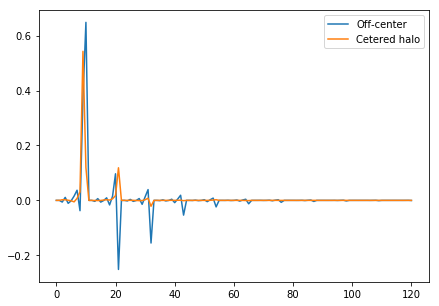

In [176]:
figure(figsize=(7,5))
plot(S0_off[:,:,2].flatten()/np.abs(np.max(S0_off)), alpha=1, label='Off-center')
plot(S0_cm[:,:,2].flatten()/np.abs(np.max(S0_cm)), alpha=1, label='Cetered halo')
legend()

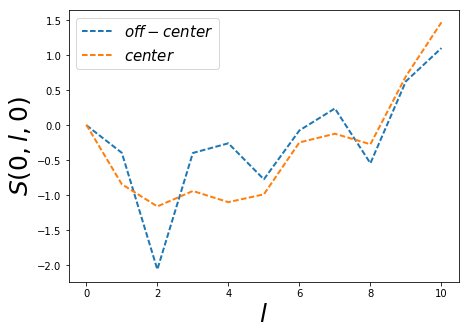

In [173]:
figure(figsize=(7,5))

plot(np.log10(np.abs(S0_off[0,:,0])/np.abs(S0_off[0,0,0])), lw=2, ls='--', label='$off-center$')
plot(np.log10(np.abs(S0_cm[0,:,0])/np.abs(S0f_cm[0,0,0])), lw=2, ls='--', label='$center$')
legend(fontsize=15)
xlabel('$l$', fontsize=25)
ylabel('$S(0, l, 0)$', fontsize=25)

## conclusion: There is effect due to the CM ! 

# truncation radii on the BFE expansion coefficients

In [9]:
def trunc_radii(pos,  r_t):
    pos_r = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2) 
    len(pos_r)
    index = np.where(pos_r < r_t)
    return pos[index]

In [10]:
pos_LMC_trunc = trunc_radii(pos_LMC_centered, 10)

In [11]:
S0_tr, T0_tr = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_trunc.astype(double)), mass_LMC.astype(double), 10, 10, 3)

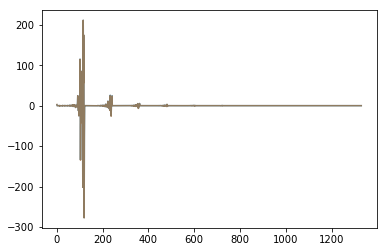

In [162]:
plot(S0_tr.flatten(), alpha=1)
plot(S0_cm.flatten(), alpha=0.5)


## conclusion: Not much effect due to the truncation radii

In [102]:
def random_res_damping(pids, pos, M, damp_perc):
    """
    Decrease the resolution of a halo by randomly selecting
    particle ids.
    
    Parameters:
    -----------
        pids : array
           1-d array with the halo particle ids.
        damp_perc : int
            percetange to decrease the halo resolution, range: [0-100].
    
    Returns:
    --------
         pids :  array
             1-d array with the randomly selected halo particle ids.
    """
    N = len(pids)
    assert((damp_perc>=0) & (damp_perc<100))
    N_indixes = int(N-N*damp_perc/100.)
    #print(N_indixes)
    random_indexes = np.random.randint(0, N, N_indixes)
    #print(random_indexes)
    return pids[random_indexes], pos[random_indexes], M[random_indexes]
    
    

97000
9700
970
97


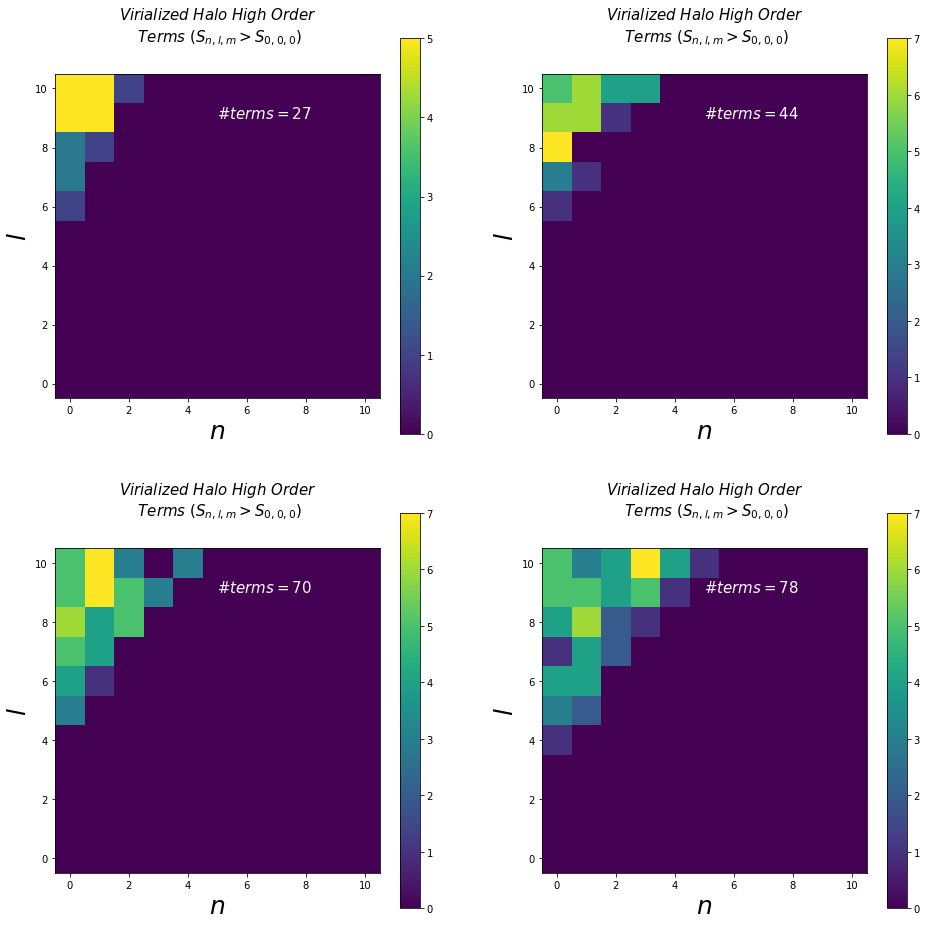

In [105]:
figure(figsize=(16,16))

subplot(2, 2, 1)
resolutions = [0, 90, 99, 99.9 ]
labels = ['100%', '50%', '10%', '1%', '0.1%']
#for i in range(len(resolutions)):
pids_lr_LMC, pos_lr_LMC, mass_lr_LMC = random_res_damping(pid_LMC, pos_LMC_centered, mass_LMC, resolutions[0])
S0_lr1, T0_lr1 = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_lr_LMC.astype(double)),
                                              mass_LMC.astype(double), 10, 10, 3)
print(len(pos_lr_LMC))
coeffs = high_order_terms(S0_lr1)
grid_coeff_vir_LR = high_order_grid(coeffs)
imshow(grid_coeff_vir_LR.T, origin='lower')
colorbar()
xlabel('$n$', fontsize=25)
ylabel('$l$', fontsize=25)
text(5, 9, '$\# terms = $'+str(len(coeffs)), color='w', fontsize=15)
title('$Virialized\ Halo\ High\ Order$' '\n $Terms\ (S_{n,l,m}> S_{0,0,0})$', fontsize=15,  y=1.08)

subplot(2, 2, 2)

pids_lr_LMC, pos_lr_LMC, mass_lr_LMC = random_res_damping(pid_LMC, pos_LMC_centered, mass_LMC, resolutions[1])
S0_lr1, T0_lr1 = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_lr_LMC.astype(double)),
                                              mass_LMC.astype(double), 10, 10, 3)
print(len(pos_lr_LMC))
coeffs = high_order_terms(S0_lr1)
grid_coeff_vir_LR = high_order_grid(coeffs)
imshow(grid_coeff_vir_LR.T, origin='lower')
colorbar()
xlabel('$n$', fontsize=25)
ylabel('$l$', fontsize=25)
text(5, 9, '$\# terms = $'+str(len(coeffs)), color='w', fontsize=15)
title('$Virialized\ Halo\ High\ Order$' '\n $Terms\ (S_{n,l,m}> S_{0,0,0})$', fontsize=15,  y=1.08)

subplot(2, 2, 3)


pids_lr_LMC, pos_lr_LMC, mass_lr_LMC = random_res_damping(pid_LMC, pos_LMC_centered, mass_LMC, resolutions[2])
S0_lr1, T0_lr1 = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_lr_LMC.astype(double)),
                                              mass_LMC.astype(double), 10, 10, 3)
print(len(pos_lr_LMC))
coeffs = high_order_terms(S0_lr1)
grid_coeff_vir_LR = high_order_grid(coeffs)
imshow(grid_coeff_vir_LR.T, origin='lower')
colorbar()
xlabel('$n$', fontsize=25)
ylabel('$l$', fontsize=25)
text(5, 9, '$\# terms = $'+str(len(coeffs)), color='w', fontsize=15)
title('$Virialized\ Halo\ High\ Order$' '\n $Terms\ (S_{n,l,m}> S_{0,0,0})$', fontsize=15,  y=1.08)

subplot(2, 2, 4)
pids_lr_LMC, pos_lr_LMC, mass_lr_LMC = random_res_damping(pid_LMC, pos_LMC_centered, mass_LMC, resolutions[3])
S0_lr1, T0_lr1 = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_lr_LMC.astype(double)),
                                              mass_LMC.astype(double), 10, 10, 3)
print(len(pos_lr_LMC))
coeffs = high_order_terms(S0_lr1)
grid_coeff_vir_LR = high_order_grid(coeffs)
imshow(grid_coeff_vir_LR.T, origin='lower')
colorbar()
xlabel('$n$', fontsize=25)
ylabel('$l$', fontsize=25)
text(5, 9, '$\# terms = $'+str(len(coeffs)), color='w', fontsize=15)
title('$Virialized\ Halo\ High\ Order$' '\n $Terms\ (S_{n,l,m}> S_{0,0,0})$', fontsize=15,  y=1.08)

# Checking the Analyitc function

In [228]:
## 
from scipy.special import gamma
from scipy.special import factorial

def a_nl(n, l):
    k_nl = 0.5*n*(n+4*l+3) + (l+1)*(2*l+1)
    A_nl = - 2**(8*l+6)/(4*np.pi*k_nl) * (factorial(n)*(n+2*l+3/2.) * (gamma(2*l+3/2.))**2) / (gamma(n+4*l+3))
    return A_nl
    

In [222]:
A_nl_grid = np.zeros((20,10))

for i in range(20):
    for j in range(10):
        A_nl_grid[i][j] = a_nl(i,j)

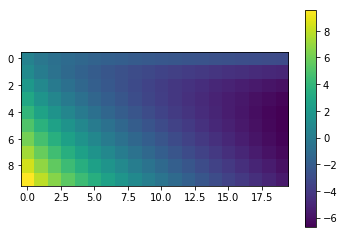

In [235]:
imshow(log10(np.abs((A_nl_grid.T))))
colorbar()

In [236]:
from scipy.special import sph_harm

In [237]:
sph_harm?